## 1数据获取

In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression as LR

data = pd.read_csv('cs-training.csv',index_col=0)
data.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [2]:
data.shape

(150000, 11)

In [3]:
data.info()
# 在MonthlyIncome和NumberOfDependents里有空值

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtype

## 2数据清洗

### 数据去重

In [4]:
data.drop_duplicates(inplace=True)
data.index = range(data.shape[0])# 这一步是将去重后的数据index改成连续上升，不会跳
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149391 entries, 0 to 149390
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      149391 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  149391 non-null  float64
 2   age                                   149391 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  149391 non-null  int64  
 4   DebtRatio                             149391 non-null  float64
 5   MonthlyIncome                         120170 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       149391 non-null  int64  
 7   NumberOfTimes90DaysLate               149391 non-null  int64  
 8   NumberRealEstateLoansOrLines          149391 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  149391 non-null  int64  
 10  NumberOfDependents                    145563 non-null  float64
dtype

### 缺失值处理

含有缺失值的特征为MonthlyIncome和NumberOfDependents，其中后者缺失只有2.5%，这些值的填充不会显著影响样本的总体特征，可以选择直接忽略掉这部分数据，或者使用均值来填充，我们这里选择均值填充。而前者则由将近20%数据缺失，所以需要更细致的处理办法。

In [5]:
data.isnull().sum()/data.shape[0]

SeriousDlqin2yrs                        0.000000
RevolvingUtilizationOfUnsecuredLines    0.000000
age                                     0.000000
NumberOfTime30-59DaysPastDueNotWorse    0.000000
DebtRatio                               0.000000
MonthlyIncome                           0.195601
NumberOfOpenCreditLinesAndLoans         0.000000
NumberOfTimes90DaysLate                 0.000000
NumberRealEstateLoansOrLines            0.000000
NumberOfTime60-89DaysPastDueNotWorse    0.000000
NumberOfDependents                      0.025624
dtype: float64

In [6]:
data["NumberOfDependents"].fillna(int(data["NumberOfDependents"].mean()), inplace=True)
# 填充NumberOfDependents列空值

针对MonthlyIncome我们可以有这样的推断，在如果数据的缺失不是由业务人员产生的，而是由客户遗漏导致，那么我们可以认定MonthlyIncome有缺失的这些客户收入应该都属于比较低的区间，因为高收入有助于信用卡的申请可以说算是一个常识，而这些客户遗漏就说明他们知道自己的月收入不会成为信用评分的有力因素，甚至会成为一个负面因素。
但是前面也说了，推断是基于业务人员不是数据缺失原因这一假设，所以更加合理的方法是：如果有大规模的数据异常，先去和业务人员沟通，观察异常是如何产生的，再根据异常的来源进行合理的数据处理。

这里我们用随机森林回归进行缺失值的填充

In [7]:
def fill_missing_rf(X,y,to_fill):

    #构建新特征矩阵和新标签
    df = X.copy()
    fill = df.loc[:,to_fill]
    df = pd.concat([df.loc[:,df.columns != to_fill],pd.DataFrame(y)],axis=1)

    # 找出我们的训练集和测试集
    Ytrain = fill[fill.notnull()]
    Ytest = fill[fill.isnull()]
    Xtrain = df.loc[Ytrain.index,:]
    Xtest = df.loc[Ytest.index,:]
    # 这里其实应该是要loc，但是前面在去重的时候，重新编号index，导致index和所在位置号码是一样的，因此去出Ytrain.index后用loc或iloc没有区别
    
    #用随机森林回归来填补缺失值
    from sklearn.ensemble import RandomForestRegressor as rfr
    rfr = rfr(n_estimators=100)
    rfr = rfr.fit(Xtrain, Ytrain)
    Ypredict = rfr.predict(Xtest)
    
    return Ypredict

X = data.iloc[:,1:]
y = data["SeriousDlqin2yrs"]

#将参数输入函数
y_pred = fill_missing_rf(X,y,"MonthlyIncome")

#注意可以通过以下代码检验数据是否数量相同
y_pred.shape ==  data.loc[data.loc[:,"MonthlyIncome"].isnull(),"MonthlyIncome"].shape

#确认我们的结果合理之后，我们就可以将数据覆盖了
data.loc[data.loc[:,"MonthlyIncome"].isnull(),"MonthlyIncome"] = y_pred

#查看数据集信息
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149391 entries, 0 to 149390
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      149391 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  149391 non-null  float64
 2   age                                   149391 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  149391 non-null  int64  
 4   DebtRatio                             149391 non-null  float64
 5   MonthlyIncome                         149391 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       149391 non-null  int64  
 7   NumberOfTimes90DaysLate               149391 non-null  int64  
 8   NumberRealEstateLoansOrLines          149391 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  149391 non-null  int64  
 10  NumberOfDependents                    149391 non-null  float64
dtype

### 异常值处理

现实数据永远都会有一些异常值，首先我们要去把他们捕捉出来，然后观察他们的性质。注意，我们并不是要排除掉所有异常值，相反很多时候，异常值是我们的重点研究对象，比如说，双十一中购买量超高的品牌，或课堂上让很多学生都兴奋的课题，这些是我们要重点研究观察的。

日常处理异常值，我们使用箱线图或者3σ法则来找到异常值。但在银行数据中，我们希望排除的“异常值”不是一些超高或超低的数字，而是一些不符合常理的数据：比如，收入不能为负数，但是一个超高水平的收入却是合理的，可以存在的。所以在银行业中，我们往往就使用普通的描述性统计来观察数据的异常与否与数据的分布情况。注意，这种方法只能在特征量有限的情况下进行，如果有几百个特征又无法成功降维或特征选择不管用，那还是用3σ比较好。

In [8]:
data.describe([0.01,0.1,0.25,.5,.75,.9,.99]).T

,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
SeriousDlqin2yrs,149391.0,0.066999,0.250021,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.0
RevolvingUtilizationOfUnsecuredLines,149391.0,6.071087,250.263672,0.0,0.0,0.003199,0.030132,0.154235,0.556494,0.978007,1.093922,50708.0
age,149391.0,52.306237,14.725962,0.0,24.0,33.000000,41.000000,52.000000,63.000000,72.000000,87.000000,109.0
NumberOfTime30-59DaysPastDueNotWorse,149391.0,0.393886,3.852953,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000,98.0
DebtRatio,149391.0,354.436740,2041.843455,0.0,0.0,0.034991,0.177441,0.368234,0.875279,1275.000000,4985.100000,329664.0
MonthlyIncome,149391.0,5424.923848,13238.280905,0.0,0.0,0.170000,1800.000000,4420.000000,7416.000000,10800.000000,23256.100000,3008750.0
NumberOfOpenCreditLinesAndLoans,149391.0,8.480892,5.136515,0.0,0.0,3.000000,5.000000,8.000000,11.000000,15.000000,24.000000,58.0
NumberOfTimes90DaysLate,149391.0,0.238120,3.826165,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,98.0
NumberRealEstateLoansOrLines,149391.0,1.022391,1.130196,0.0,0.0,0.000000,0.000000,1.000000,2.000000,2.000000,4.000000,54.0
NumberOfTime60-89DaysPastDueNotWorse,149391.0,0.212503,3.810523,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,98.0


信用评分应该是针对成年人，这里竟然出现了年龄最小值为0，这应该异常，查询可知，只有一个客户，因此直接删除

In [9]:
(data["age"]==0).sum()

1

In [10]:
data = data[data["age"] != 0]

有三个指标看起来很奇怪： "NumberOfTime30-59DaysPastDueNotWorse" 、"NumberOfTime60-89DaysPastDueNotWorse"、 "NumberOfTimes90DaysLate" 这三个指标分别是“过去两年内出现35-59天逾期但是没有发展的更坏的次数”，“过去两年内出现60-89天逾期但是没 有发展的更坏的次数”，“过去两年内出现90天逾期的次数”。这三个指标，在99%的分布的时候依然是2，最大值却是 98，看起来非常奇怪。一个人在过去两年内逾期35~59天98次，一年6个60天，两年内逾期98次这是怎么算出来的？ 我们可以去咨询业务人员，请教他们这个逾期次数是如何计算的。

在没有办法询问业务人员的情况下，我们自己进行推断。首先对于指标"NumberOfTime30-59DaysPastDueNotWorse"，两年总共730天，这一列的值最大是730/30=24,所以24以上的值应该都属于异常值，查询可得，这些值在96-98之间,共有225个。同理指标"NumberOfTime60-89DaysPastDueNotWorse"的值最大只能是12,12以上的值都属于异常值，这些值也在96-98之间，共有225个。"NumberOfTimes90DaysLate"也是一样。

同时这些异常值的客户预测值有0有1，所以也排除因为客户信用非常低，所以我强行拔高所有指标，导致客户无论如何都不能获得信用卡的假设。他们应该只是纯粹的坏数据。

In [11]:
(data["NumberOfTime60-89DaysPastDueNotWorse"]>12).sum()

225

In [12]:
(data["NumberOfTime30-59DaysPastDueNotWorse"]>24).sum()

225

In [13]:
max(list(data.loc[data["NumberOfTime30-59DaysPastDueNotWorse"]>24,  "NumberOfTime30-59DaysPastDueNotWorse"]))

98

In [14]:
data.loc[data["NumberOfTime30-59DaysPastDueNotWorse"]>24,  "SeriousDlqin2yrs"]

1732      1
2285      0
3883      0
4416      0
4704      0
         ..
146667    1
147180    1
148548    1
148634    0
148833    1
Name: SeriousDlqin2yrs, Length: 225, dtype: int64

In [15]:
data = data[data["NumberOfTime60-89DaysPastDueNotWorse"]<=12]
data.index = range(data.shape[0])

In [16]:
data.describe([0.01,0.1,0.25,.5,.75,.9,.99]).T

,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
SeriousDlqin2yrs,149165.0,0.066188,0.248612,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,1.0
RevolvingUtilizationOfUnsecuredLines,149165.0,6.078770,250.453111,0.0,0.0,0.003174,0.030033,0.153615,0.553698,0.97502,1.094061,50708.0
age,149165.0,52.331076,14.714114,21.0,24.0,33.000000,41.000000,52.000000,63.000000,72.00000,87.000000,109.0
NumberOfTime30-59DaysPastDueNotWorse,149165.0,0.246720,0.698935,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.00000,3.000000,13.0
DebtRatio,149165.0,354.963542,2043.344496,0.0,0.0,0.036385,0.178211,0.368619,0.876994,1277.30000,4989.360000,329664.0
MonthlyIncome,149165.0,5428.973336,13247.284748,0.0,0.0,0.170000,1800.000000,4434.000000,7419.000000,10800.00000,23252.160000,3008750.0
NumberOfOpenCreditLinesAndLoans,149165.0,8.493688,5.129841,0.0,1.0,3.000000,5.000000,8.000000,11.000000,15.00000,24.000000,58.0
NumberOfTimes90DaysLate,149165.0,0.090725,0.486354,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,2.000000,17.0
NumberRealEstateLoansOrLines,149165.0,1.023927,1.130350,0.0,0.0,0.000000,0.000000,1.000000,2.000000,2.00000,4.000000,54.0
NumberOfTime60-89DaysPastDueNotWorse,149165.0,0.065069,0.330675,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,2.000000,11.0


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149165 entries, 0 to 149164
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      149165 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  149165 non-null  float64
 2   age                                   149165 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  149165 non-null  int64  
 4   DebtRatio                             149165 non-null  float64
 5   MonthlyIncome                         149165 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       149165 non-null  int64  
 7   NumberOfTimes90DaysLate               149165 non-null  int64  
 8   NumberRealEstateLoansOrLines          149165 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  149165 non-null  int64  
 10  NumberOfDependents                    149165 non-null  float64
dtype

### 样本不平衡

In [18]:
# 探索标签的分布
X = data.iloc[:,1:]
y = data.iloc[:,0]

y.value_counts()#查看每一类别值得数据量，查看样本是否均衡

0    139292
1      9873
Name: SeriousDlqin2yrs, dtype: int64

可以看出，样本严重不均衡。虽然大家都在努力防范信用风险，但实际违约的人并不多。并且，银行并不会真的一棒子打死所有会违约的人，很多人是会还钱的，只是忘记了还款日，很多人是不愿意欠人钱的，但是当时真的很困难，资金周转不过来，所以发生逾期，但一旦他有了钱，他就会把钱换上。对于银行来说，只要你最后能够把钱还上，我都愿意借钱给你，因为我借给你就有收入（利息）。所以，对于银行来说，真正想要被判别出来的其实是”恶意违约“的人，而这部分人数非常非常少，样本就会不均衡。这一直是银行业建模的一个痛点：我们永远希望捕捉少数类。逻辑回归中使用最多的是上采样方法来平衡样本。

In [19]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42) #实例化
X,y = sm.fit_resample(X,y)    #训练模型

y.value_counts()# 将原本较少的判断为1的客户数据个数9873扩展成和0的客户数据个数一样139292

1    139292
0    139292
Name: SeriousDlqin2yrs, dtype: int64

In [20]:
from sklearn.model_selection import train_test_split

X = pd.DataFrame(X)
y = pd.DataFrame(y)

X_train, X_vali, Y_train, Y_vali = train_test_split(X,y,test_size=0.3,random_state=420)

#训练集
model_data = pd.concat([Y_train, X_train], axis=1)
model_data.index = range(model_data.shape[0])
model_data.columns = data.columns
#验证集
vali_data = pd.concat([Y_vali, X_vali], axis=1)
vali_data.index = range(vali_data.shape[0])
vali_data.columns = data.columns
#分别存储验证集和训练集，以便于后续操作
model_data.to_csv('./model_data.csv')#训练数据
vali_data.to_csv('./vali_data.csv')#验证数据

## 3特征工程

在前面我们已经对数据进行了清洗：数据去重、缺失值处理、异常值处理、样本不平衡处理。现在我们需要进行特征工程。

而在信用卡评分领域，通常在这一步进行分箱，本质就是将连续变量离散化。首先，要分多少个箱子才合适？最开始我们并不知道，但是既然是将连续型变量离散化，想也知道箱子个数必然不能太多，最好控制在十个以下。而用来制作评分卡，最好能在4~5个为最佳。我们知道，离散化连续变量必然伴随着信息的损失，并且箱子越少，信息损失越大。为了衡量特征上的信息量以及特征对预测函数的贡献，银行业定义了概念Information value(IV)：
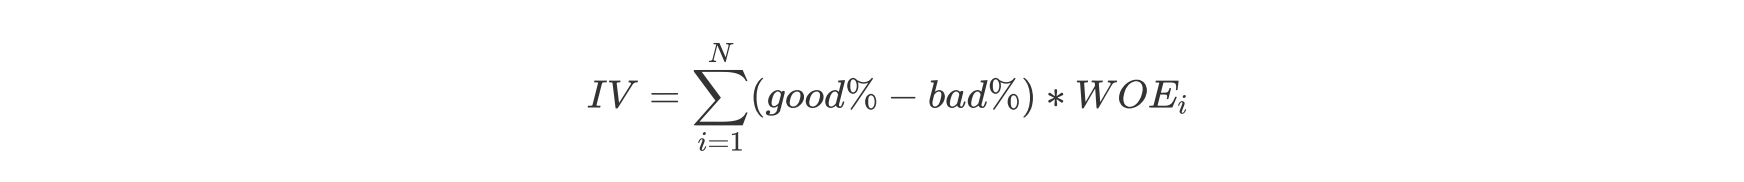
其中N是这个特征上箱子的个数，i代表每个箱子，good%是这个箱内的优质客户（标签为0的客户）占整个特征中所有优质客户的比例，bad%是这个箱子里的坏客户（就是那些会违约，标签为1的那些客户）占整个特征中所有坏客户的比例，而WOEi则写作：
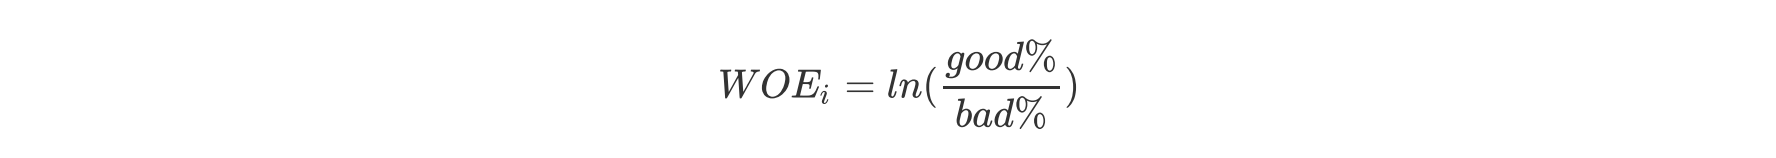
这是我们在银行业中用来衡量违约概率的指标，中文叫做证据权重(weight of Evidence)，本质其实就是优质客户比上坏客户的比例的对数。WOE是对一个箱子来说的，WOE越大，代表了这个箱子里的优质客户越多。而IV是对整个特征来说的，IV代表的意义是我们特征上的信息量以及这个特征对模型的贡献，由下表来控制：
<img src="pic/202107222357.png" width = "70%" />
可见，IV并非越大越好，我们想要找到IV的大小和箱子个数的平衡点。箱子越多，IV必然越大，因为信息损失会非常少。所以，我们会对特征进行分箱，然后计算每个特征在n个箱子数目下的WOE值，利用IV值的曲线，找出每个特征合适的分箱个数。

下面的分箱策略就是，先分较多的箱子，然后每一步进行箱子的合并，找到能用较少的箱子同时得到较大的IV的临界点

### 画出IV关于箱子个数的曲线

In [21]:
def graphforbestbin(DF, X, Y, n=5,q=20,graph=True):
    '''
    自动最优分箱函数，基于卡方检验的分箱

    参数：
    DF: 需要输入的数据
    X: 需要分箱的列名
    Y: 分箱数据对应的标签 Y 列名
    n: 保留分箱个数
    q: 初始分箱的个数
    graph: 是否要画出IV图像

    区间为前开后闭 (]

    '''

    DF = DF[[X,Y]].copy()
    # 初始分箱
    DF["qcut"],bins = pd.qcut(DF[X], retbins=True, q=q,duplicates="drop")
    coount_y0 = DF.loc[DF[Y]==0].groupby(by="qcut").count()[Y]
    coount_y1 = DF.loc[DF[Y]==1].groupby(by="qcut").count()[Y]
    num_bins = [*zip(bins,bins[1:],coount_y0,coount_y1)]
    # 使得每一个箱子内都有正负两种样本
    for i in range(q):
        if 0 in num_bins[0][2:]:
            num_bins[0:2] = [(
                num_bins[0][0],
                num_bins[1][1],
                num_bins[0][2]+num_bins[1][2],
                num_bins[0][3]+num_bins[1][3])]
            continue

        for i in range(len(num_bins)):
            if 0 in num_bins[i][2:]:
                num_bins[i-1:i+1] = [(
                    num_bins[i-1][0],
                    num_bins[i][1],
                    num_bins[i-1][2]+num_bins[i][2],
                    num_bins[i-1][3]+num_bins[i][3])]
                break
        else:
            break
    # 得到每个箱子的woe
    def get_woe(num_bins):
        columns = ["min","max","count_0","count_1"]
        df = pd.DataFrame(num_bins,columns=columns)
        df["total"] = df.count_0 + df.count_1
        df["percentage"] = df.total / df.total.sum()
        df["bad_rate"] = df.count_1 / df.total
        df["good%"] = df.count_0/df.count_0.sum()
        df["bad%"] = df.count_1/df.count_1.sum()
        df["woe"] = np.log(df["good%"] / df["bad%"])
        return df
    # 得到某个特征在特定分箱下的IV值
    def get_iv(df):
        rate = df["good%"] - df["bad%"]
        iv = np.sum(rate * df.woe)
        return iv
    # 这里的循环是为了得到IV关于箱子数的曲线，从而观察得到最佳分箱数
    IV = []
    axisx = []
    while len(num_bins) > n:
        pvs = []
        for i in range(len(num_bins)-1):
            x1 = num_bins[i][2:]
            x2 = num_bins[i+1][2:]
            pv = scipy.stats.chi2_contingency([x1,x2])[1]
            pvs.append(pv)

        i = pvs.index(max(pvs))
        num_bins[i:i+2] = [(
            num_bins[i][0],
            num_bins[i+1][1],
            num_bins[i][2]+num_bins[i+1][2],
            num_bins[i][3]+num_bins[i+1][3])]

        bins_df = pd.DataFrame(get_woe(num_bins))
        axisx.append(len(num_bins))
        IV.append(get_iv(bins_df))

    if graph:
        plt.figure()
        plt.plot(axisx,IV)
        plt.xticks(axisx)
        plt.xlabel("number of box")
        plt.ylabel("IV")
        plt.show()
    return bins_df

RevolvingUtilizationOfUnsecuredLines


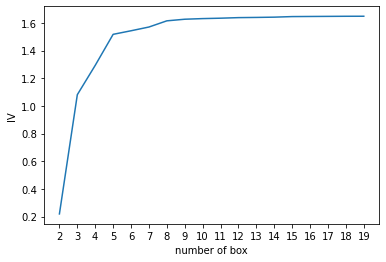

age


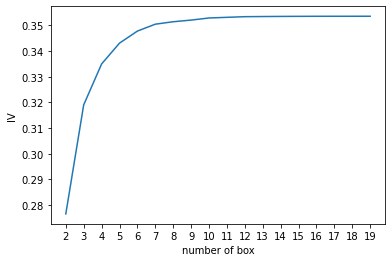

DebtRatio


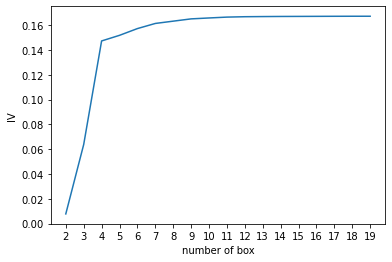

MonthlyIncome


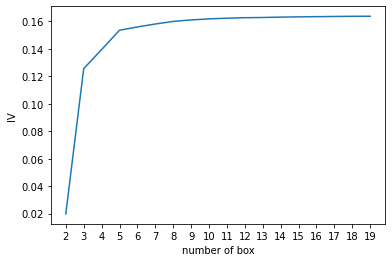

NumberOfOpenCreditLinesAndLoans


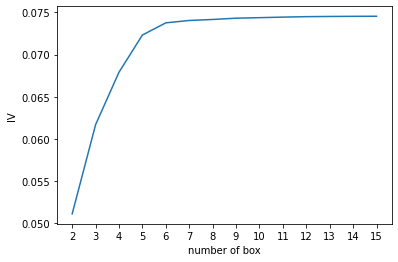

In [22]:
columns = ["RevolvingUtilizationOfUnsecuredLines", "age", "DebtRatio", "MonthlyIncome", "NumberOfOpenCreditLinesAndLoans"]

for i in columns:
    print(i)
    graphforbestbin(model_data,i,"SeriousDlqin2yrs",n=2,q=20)

从我们得到的IV关于箱数的曲线来看，"RevolvingUtilizationOfUnsecuredLines"，"age"，"DebtRatio"，"MonthlyIncome"，"NumberOfOpenCreditLinesAndLoans"四列顺利出图，并且可以直接从图中得到最佳的分箱情况。而其它列要不就是图片空白，要不就是报错。这是因为我们最初要求初分箱为20组，但是有一些列分不成20组，比如一个家庭的成员个数不可能会在20个区间内，那我们对这些列要做的就是手动分箱

### 将自动和手动分箱的特征分开处理

In [23]:
auto_col_bins = {"RevolvingUtilizationOfUnsecuredLines":6,
                "age":5,
                "DebtRatio":4,
                "MonthlyIncome":3,
                "NumberOfOpenCreditLinesAndLoans":5}

hand_bins = {"NumberOfTime30-59DaysPastDueNotWorse":[0,1,2,13]
            ,"NumberOfTimes90DaysLate":[0,1,2,17]
            ,"NumberRealEstateLoansOrLines":[0,1,2,4,54]
            ,"NumberOfTime60-89DaysPastDueNotWorse":[0,1,2,8]
            ,"NumberOfDependents":[0,1,2,3]}

hand_bins = {k:[-np.inf,*v[:-1],np.inf] for k,v in hand_bins.items()}
hand_bins

{'NumberOfTime30-59DaysPastDueNotWorse': [-inf, 0, 1, 2, inf],
 'NumberOfTimes90DaysLate': [-inf, 0, 1, 2, inf],
 'NumberRealEstateLoansOrLines': [-inf, 0, 1, 2, 4, inf],
 'NumberOfTime60-89DaysPastDueNotWorse': [-inf, 0, 1, 2, inf],
 'NumberOfDependents': [-inf, 0, 1, 2, inf]}

In [24]:
model_data.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0.015404,53,0,0.121802,4728.0,5,0,0,0,0.000000
1,0,0.168311,63,0,0.141964,1119.0,5,0,0,0,0.000000
2,1,1.063570,39,1,0.417663,3500.0,5,1,0,2,3.716057
3,0,0.088684,73,0,0.522822,5301.0,11,0,2,0,0.000000
4,1,0.622999,53,0,0.423650,13000.0,9,0,2,0,0.181999


这一步，得到的是字典，键是列名，值是这一列分箱的边界值组成的列表

In [25]:
bins_of_col = {}
for col in auto_col_bins:
    bins_df = graphforbestbin(model_data,col
                             ,"SeriousDlqin2yrs"
                             ,n=auto_col_bins[col]
                             #使用字典的性质来取出每个特征所对应的箱的数量
                             ,q=20
                             ,graph=False)
    bins_list = sorted(set(bins_df["min"]).union(bins_df["max"]))
    #保证区间覆盖使用 np.inf 替换最大值 -np.inf 替换最小值
    bins_list[0],bins_list[-1] = -np.inf,np.inf
    bins_of_col[col] = bins_list
bins_of_col.update(hand_bins)
bins_of_col

{'RevolvingUtilizationOfUnsecuredLines': [-inf,
  0.09912004375,
  0.29795157950623663,
  0.46536097219492734,
  0.9827922991395618,
  0.9999998999999999,
  inf],
 'age': [-inf, 36.0, 54.0, 61.0, 74.0, inf],
 'DebtRatio': [-inf,
  0.017354371398751893,
  0.40157031652930225,
  1.4665412398,
  inf],
 'MonthlyIncome': [-inf, 0.09526742804043906, 4600.0, inf],
 'NumberOfOpenCreditLinesAndLoans': [-inf, 1.0, 3.0, 5.0, 17.0, inf],
 'NumberOfTime30-59DaysPastDueNotWorse': [-inf, 0, 1, 2, inf],
 'NumberOfTimes90DaysLate': [-inf, 0, 1, 2, inf],
 'NumberRealEstateLoansOrLines': [-inf, 0, 1, 2, 4, inf],
 'NumberOfTime60-89DaysPastDueNotWorse': [-inf, 0, 1, 2, inf],
 'NumberOfDependents': [-inf, 0, 1, 2, inf]}

### 得到每一个样本每一个特征的woe取值

In [26]:
def get_woe(df,col,y,bins):
    df = df[[col,y]].copy()
    df["cut"] = pd.cut(df[col],bins)
    bins_df = df.groupby("cut")[y].value_counts().unstack()
    woe = bins_df["woe"] = np.log((bins_df[0]/bins_df[0].sum())/(bins_df[1]/bins_df[1].sum()))
    return woe


woeall = {}
for col in bins_of_col:
    woeall[col] = get_woe(model_data,col,"SeriousDlqin2yrs",bins_of_col[col])

model_woe = pd.DataFrame(index=model_data.index)
model_woe["age"] = pd.cut(model_data["age"],bins_of_col["age"]).map(woeall["age"])
# 首先，pd.cut(model_data["age"],bins_of_col["age"])得到的是，age这一列数据，根据已有的区间进行划分，每行数据划分进了哪个区间
# 而woeall["age"]则是一个区间的woe是多少，map函数则是用这个woe值替代每一行数据对应的区间

for col in bins_of_col:
    model_woe[col] = pd.cut(model_data[col],bins_of_col[col]).map(woeall[col])

model_woe["SeriousDlqin2yrs"] = model_data["SeriousDlqin2yrs"]
model_woe.head()

,age,RevolvingUtilizationOfUnsecuredLines,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,SeriousDlqin2yrs
0,-0.279927,2.204883,0.036351,0.156186,-0.057975,0.352626,0.234636,-0.392418,0.124162,0.623142,0
1,1.008823,0.667443,0.036351,-0.258983,-0.057975,0.352626,0.234636,-0.392418,0.124162,0.623142,0
2,-0.279927,-2.046318,-0.388532,-0.258983,-0.057975,-0.872820,-1.751961,-0.392418,-1.772045,-0.479623,1
3,1.008823,2.204883,-0.388532,0.156186,0.124381,0.352626,0.234636,0.616164,0.124162,0.623142,0
4,-0.279927,-1.073279,-0.388532,0.156186,0.124381,0.352626,0.234636,0.616164,0.124162,-0.577333,1


### 将测试集的样本初始数据也用训练集算出的woe替代

In [27]:
vali_woe = pd.DataFrame(index=vali_data.index)

for col in bins_of_col:
    vali_woe[col] = pd.cut(vali_data[col],bins_of_col[col]).map(woeall[col])

vali_woe["SeriousDlqin2yrs"] = vali_data["SeriousDlqin2yrs"]

## 4训练逻辑回归模型

In [28]:
vali_X = vali_woe.iloc[:,:-1]
vali_y = vali_woe.iloc[:,-1]
X = model_woe.iloc[:,:-1]
y = model_woe.iloc[:,-1]

from sklearn.linear_model import LogisticRegression as LR

lr = LR().fit(X,y)
lr.score(vali_X,vali_y)
# 划分的每个区间的离散化的量时是woe,为什么？

0.7761917296831626

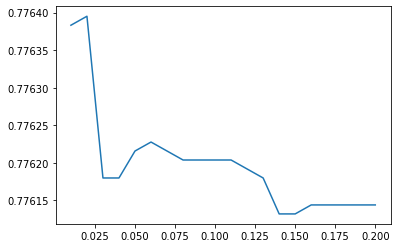

In [29]:
c_1 = np.linspace(0.01,1,20)
c_2 = np.linspace(0.01,0.2,20)

score = []
for i in c_2: 
    lr = LR(solver='liblinear',C=i).fit(X,y)
    # 参数C是正则化力度
    score.append(lr.score(vali_X,vali_y))
plt.figure()
plt.plot(c_2,score)
plt.show()

In [30]:
'''
lr.n_iter_

score = []
for i in [1,2,3,4,5,6,7,8,9,10]: 
    lr = LR(solver='liblinear',C=0.025,max_iter=i).fit(X,y)
    score.append(lr.score(vali_X,vali_y))
plt.figure()
plt.plot([1,2,3,4,5,6,7,8,9,10],score)
plt.show()
'''

"\nlr.n_iter_\n\nscore = []\nfor i in [1,2,3,4,5,6,7,8,9,10]: \n    lr = LR(solver='liblinear',C=0.025,max_iter=i).fit(X,y)\n    score.append(lr.score(vali_X,vali_y))\nplt.figure()\nplt.plot([1,2,3,4,5,6,7,8,9,10],score)\nplt.show()\n"

              0         1
0      0.909521  0.090479
1      0.549078  0.450922
2      0.877010  0.122990
3      0.832192  0.167808
4      0.303358  0.696642
...         ...       ...
83571  0.371247  0.628753
83572  0.095819  0.904181
83573  0.292054  0.707946
83574  0.036612  0.963388
83575  0.037168  0.962832

[83576 rows x 2 columns]


<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

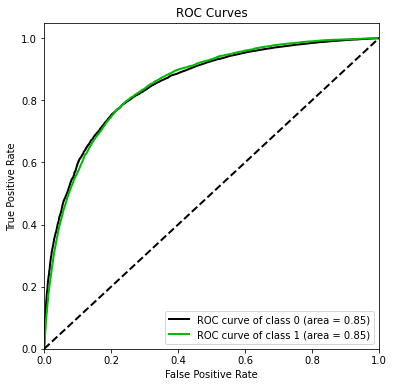

In [31]:
import scikitplot as skplt

vali_proba_df = pd.DataFrame(lr.predict_proba(vali_X))
print(vali_proba_df)
skplt.metrics.plot_roc(vali_y, vali_proba_df, plot_micro=False,figsize=(6,6), plot_macro=False)
# ROC有两个曲线的原因是vali_proba_df中有两列，第一列是样本为0的概率，第二列是样本为1的概率，两列分别算，因此有两个图

## 5算出评分卡

In [32]:
B,A = 28.85390081777927, 521.8621880878296

In [33]:
base_score = A - B*lr.intercept_  
base_score

array([522.04184863])

In [34]:
score_age = woeall["age"] * (-B*lr.coef_[0][1])  #lr.coef_：每一个特征建模之后得出的系数
score_age 

cut
(-inf, 36.0]   -11.288249
(36.0, 54.0]    -6.070426
(54.0, 61.0]     5.390787
(61.0, 74.0]    21.877094
(74.0, inf]     37.051598
dtype: float64

In [35]:
file = "./ScoreData.csv"
with open(file,"w") as fdata:
    fdata.write("base_score,{}\n".format(base_score))
for i,col in enumerate(X.columns):
    score = woeall[col] * (-B*lr.coef_[0][i])
    score.name = "Score"
    score.index.name = col
    score.to_csv(file,header=True,mode="a")